In [1]:
# Импорты

import math
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from time import time 

import holidays
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error


c:\repos\Kolesa-python-exam\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# from google.oauth2 import service_account

# pd.set_option('display.max_columns', 599)
# pd.set_option('display.max_rows', 599)

# project_id = 'kolesa-android-app'
# credentials = 'C:/kolesa-android-app-715adc9bdf26.json'
# credentials = service_account.Credentials.from_service_account_file(credentials)

In [3]:
# q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"""

In [4]:
# data = pd.read_gbq(query=q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type='tqdm') # Запрос данных из GBQ

In [5]:
#ЕСЛИ У ВАС НЕТ ДОСТУПА К BQ, ТО МОЖНО ЗАГРУЗИТЬ ДАННЫЕ ЧЕРЕЗ CSV

data = pd.read_csv('Data/data.csv')
data

,event_date,y
0,2022-01-19,15360
1,2022-11-08,19712
2,2021-06-07,12801
3,2021-03-28,12801
4,2021-04-15,13314
...,...,...
1091,2022-07-24,15103
1092,2022-02-28,15615
1093,2021-10-31,16383
1094,2021-12-01,16918


In [6]:
data.sort_values(by='event_date', inplace=True)
data

,event_date,y
376,2020-01-01,5721
345,2020-01-02,8274
532,2020-01-03,9344
574,2020-01-04,9864
843,2020-01-05,10435
...,...,...
623,2022-12-27,17042
285,2022-12-28,16195
495,2022-12-29,14966
56,2022-12-30,13070


In [7]:
data['event_date'] = pd.to_datetime(data['event_date'])
data.dtypes

event_date    datetime64[ns]
y                      int64
dtype: object

In [8]:
data.columns = ['ds', 'y']
data.index = pd.to_datetime(data['ds'])
data.head()

,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435


<Axes: xlabel='ds'>

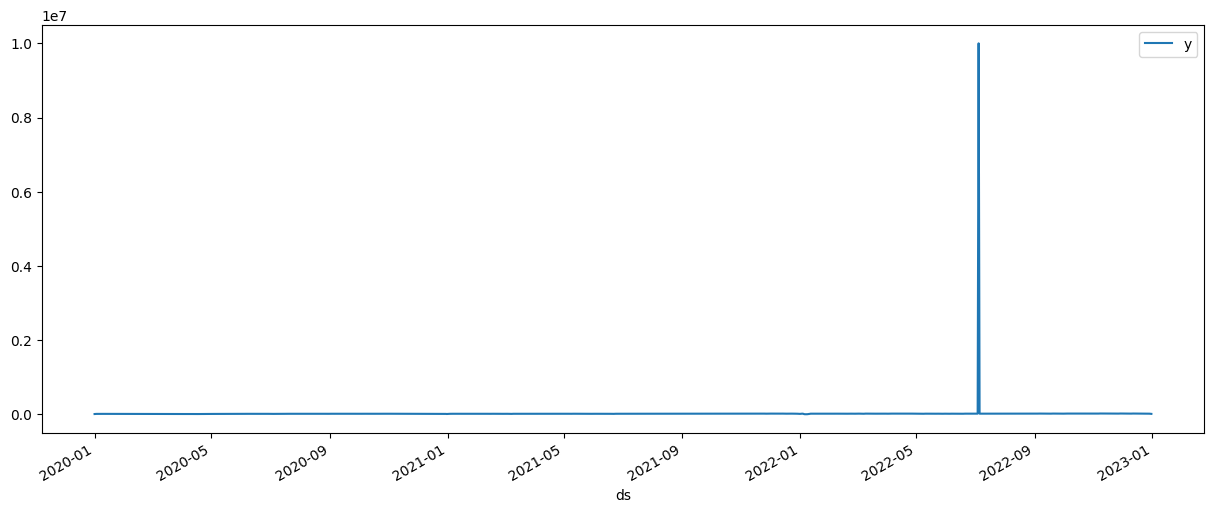

In [9]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [10]:
data.idxmax()

ds   2022-12-31
y    2022-07-05
dtype: datetime64[ns]

In [11]:
for i in range(2):
    data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()

C:\Users\lofas\AppData\Local\Temp\ipykernel_27516\1448882573.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22644.69708029197' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()


In [12]:
for i in range(5):
    data.loc[data['y'].idxmin(), 'y'] = data['y'].mean()

<Axes: xlabel='ds'>

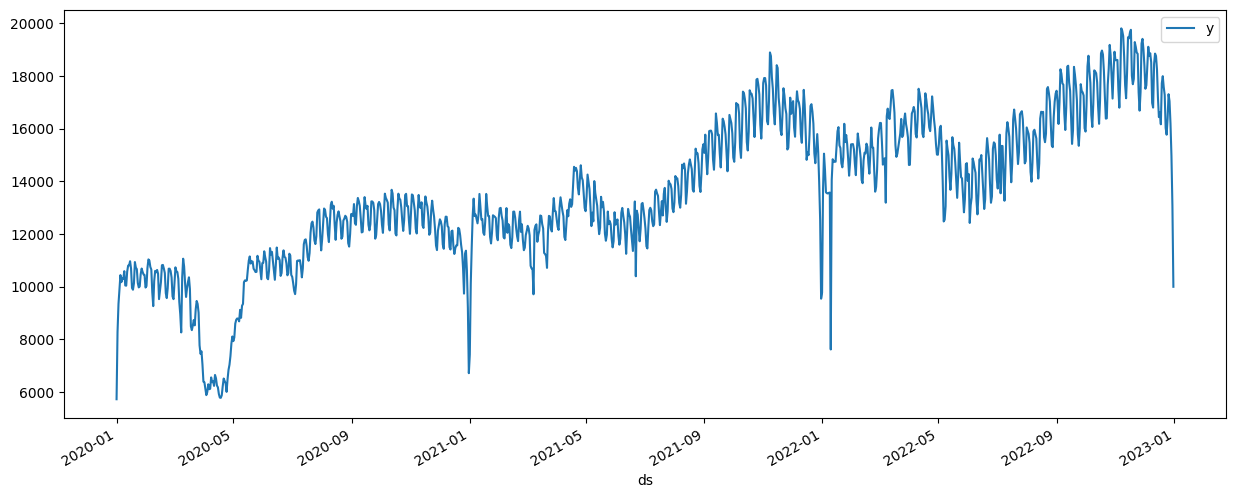

In [13]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [14]:
def is_ramadan(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-04-24')) & (date <= pd.to_datetime('2020-05-24'))
            | (date >=pd.to_datetime('2021-04-13')) & (date <= pd.to_datetime('2021-05-13'))
            | (date >=pd.to_datetime('2022-04-03')) & (date <= pd.to_datetime('2022-05-03'))
            | (date >=pd.to_datetime('2023-03-23')) & (date <= pd.to_datetime('2023-04-23')))

data['is_ramadan'] = data['ds'].apply(is_ramadan)
data['ramadan'] = data['is_ramadan'].apply(int)

def is_covid(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-03-16')) & (date <= pd.to_datetime('2020-06-01')))

data['is_covid'] = data['ds'].apply(is_covid)
data['covid'] = data['is_covid'].apply(int)
data.head()
    

,ds,y,is_ramadan,ramadan,is_covid,covid
ds,,,,,,
2020-01-01,2020-01-01,5721.0,False,0,False,0
2020-01-02,2020-01-02,8274.0,False,0,False,0
2020-01-03,2020-01-03,9344.0,False,0,False,0
2020-01-04,2020-01-04,9864.0,False,0,False,0
2020-01-05,2020-01-05,10435.0,False,0,False,0


In [15]:
from Models import DecisionTree

# Установим индекс как datetime
data.index = pd.to_datetime(data['ds'])

# Преобразуем дату в номер дня в году
def get_day_of_year(ds):
    return pd.to_datetime(ds).dayofyear

data['day_of_year'] = data['ds'].apply(get_day_of_year)

# Целевая переменная
y = data['y']

# Признаки
X = data[['day_of_year']]

# Создание и обучение модели
tree_reg = DecisionTree.TreeReg(max_depth=5, min_samples_split=2, max_leafs=20, bins=None)
tree_reg.fit(X, y)

# Предсказание
predictions = tree_reg.predict(X)

# Визуализация данных и предсказаний
plt.figure(figsize=(10, 6))
plt.scatter(data['day_of_year'], data['y'], color='blue', label='Исходные данные')
plt.plot(data['day_of_year'], predictions, color='red', label='Предсказания')
plt.title('Предсказания модели TreeReg')
plt.xlabel('Номер дня в году')
plt.ylabel('Значение y')
plt.legend()
plt.grid(True)
plt.show()

KeyError: None

In [ ]:
# # Функция для получения номера дня в году из даты
# def get_day_of_year(ds):
#     return pd.to_datetime(ds).dayofyear

# # Преобразуем дату в номер дня в году
# data['day_of_year'] = data['ds'].apply(get_day_of_year)

# # Используем столбец 'y' в качестве целевой переменной
# y = data['y'].values

# # Используем номер дня в году в качестве признака
# X = data[['day_of_year']]


In [ ]:
# from Models import DecisionTree

# # Создаем экземпляр класса TreeReg с выбранными параметрами
# tree_regressor = DecisionTree.TreeReg(max_depth=5, min_samples_split=2, max_leafs=20, bins=None)

# # Обучаем модель на данных X и y
# tree_regressor.fit(X, y)

# # Предсказываем целевую переменную на тех же данных X
# predictions = tree_regressor.predict(X)

# # Визуализируем дерево решений (если необходимо)
# # tree_regressor.print_tree(tree_regressor.node)




KeyError: "None of [DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',\n               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',\n               '2020-01-10', '2020-01-11',\n               ...\n               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',\n               '2022-12-26', '2022-12-27', '2022-12-28', '2022-12-29',\n               '2022-12-30', '2022-12-31'],\n              dtype='datetime64[ns]', name='ds', length=1093, freq=None)] are in the [index]"

Best Parameters: {'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 3}
Mean Squared Error: 6424579.288544733
